In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
import shap
import random
pd.set_option('display.max_columns', 81) 
pd.set_option('display.max_rows', 81) 

In [2]:
all_data = pd.read_excel(r"C:\Users\byron_hsing\Documents\ML_side_project\telecom_customer_churn\raw_data\Telco_customer_churn.xlsx")

In [3]:
all_data.head(2)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,Satisfaction Score,Churn Category
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,1,Competitor
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,2,Other


# 前處理

In [4]:
print('Rows and Columns:','\n',all_data.shape,'\n')
pd.DataFrame({'type':all_data.dtypes})

Rows and Columns: 
 (7043, 35) 



,type
CustomerID,object
Count,int64
Country,object
State,object
City,object
Zip Code,int64
Lat Long,object
Latitude,float64
Longitude,float64
Gender,object


In [5]:
all_data.nunique()

CustomerID            7043
Count                    1
Country                  1
State                    1
City                  1129
Zip Code              1652
Lat Long              1652
Latitude              1652
Longitude             1651
Gender                   2
Senior Citizen           2
Partner                  2
Dependents               2
Tenure Months           73
Phone Service            2
Multiple Lines           3
Internet Service         3
Online Security          3
Online Backup            3
Device Protection        3
Tech Support             3
Streaming TV             3
Streaming Movies         3
Contract                 3
Paperless Billing        2
Payment Method           4
Monthly Charges       1585
Total Charges         6531
Churn Label              2
Churn Value              2
Churn Score             85
CLTV                  3438
Churn Reason            20
Satisfaction Score       5
Churn Category           6
dtype: int64

In [6]:
all_data.isna().sum()

CustomerID               0
Count                    0
Country                  0
State                    0
City                     0
Zip Code                 0
Lat Long                 0
Latitude                 0
Longitude                0
Gender                   0
Senior Citizen           0
Partner                  0
Dependents               0
Tenure Months            0
Phone Service            0
Multiple Lines           0
Internet Service         0
Online Security          0
Online Backup            0
Device Protection        0
Tech Support             0
Streaming TV             0
Streaming Movies         0
Contract                 0
Paperless Billing        0
Payment Method           0
Monthly Charges          0
Total Charges            0
Churn Label              0
Churn Value              0
Churn Score              0
CLTV                     0
Churn Reason          5174
Satisfaction Score       0
Churn Category           0
dtype: int64

In [7]:
# 奇怪的值
all_data.loc[all_data['Total Charges']== ' ',['Total Charges']] = 0  #看到monthly charge為object超怪

# --------------------轉換變數型態---------------------------------
all_data['Churn Reason'] = all_data['Churn Reason'].fillna('Not Churn')
all_data['Zip Code'] = all_data['Zip Code'].astype(str)
all_data['Total Charges'] = all_data['Total Charges'].astype(float)

# 調整churn value欄位順序
all_data_y = all_data['Churn Value']
all_data = all_data.drop('Churn Value',axis =1)
all_data = pd.concat([all_data,all_data_y],axis = 1)

# ------------------決定變數要不要納入模型--------------------------
key_col = ['CustomerID']
others_drop = ['Count',
               'Country',
               'State',
               'Lat Long',
               'Churn Label',
               'Churn Reason',
               'Churn Category',
               'Latitude',
               'Longitude',
               'Churn Score',
              'CLTV',
              'Satisfaction Score']
# churn reason 要drop 不然開卷考
# City很多 但不考慮丟掉 用target encoding就好，如果用one hot會爆出很多變數 但使用上還是要注意極端值
# CLTV不丟掉原因是因為EDA看到CLTV不會洩漏變數
# churn score也丟掉原因是因為那是IBM預測的
all_data_drop = all_data.drop(key_col+others_drop,axis = 1)
del(all_data)



In [8]:
all_data_drop.shape

(7043, 22)

# EDA

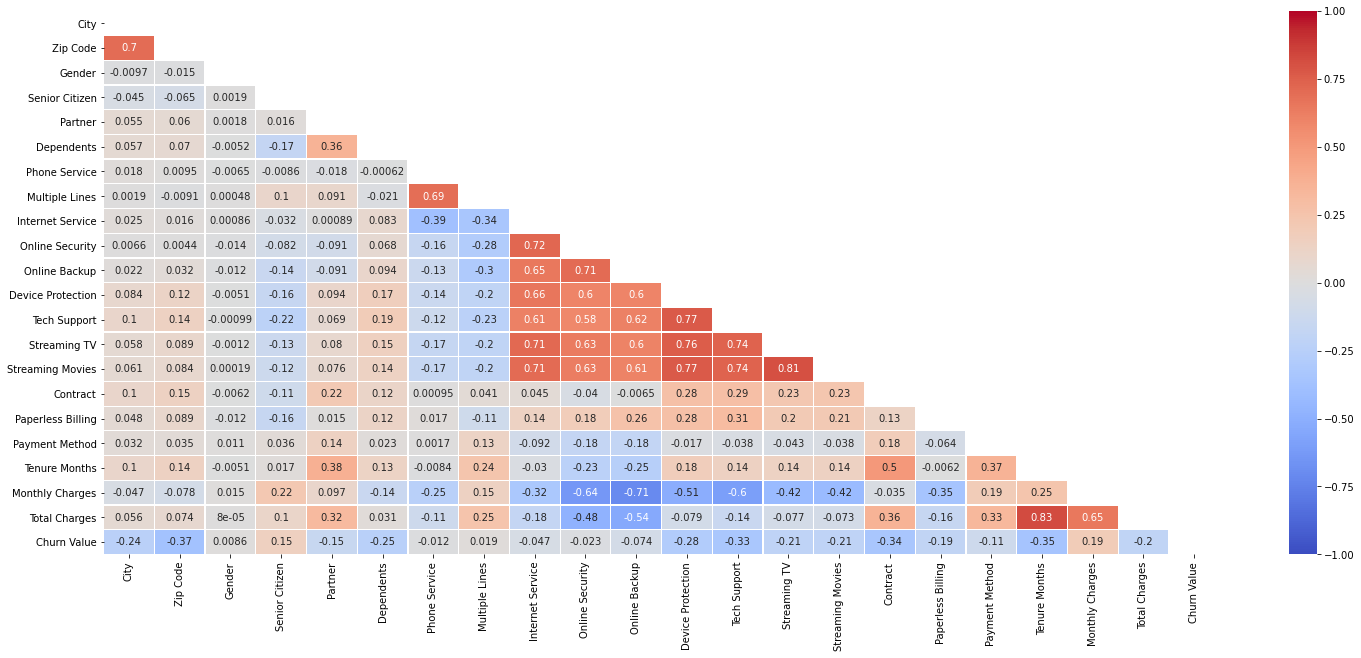

In [9]:
# Correlation between all variables
X = all_data_drop.drop(['Churn Value'],axis = 1)
numeric_feature = X.select_dtypes(exclude=['O']).columns.to_list()
categorical_feature = X.select_dtypes(include=['O']).columns.to_list()
y = all_data_drop['Churn Value']

plt.figure(5, figsize=(25, 10))
categorical_X = X[categorical_feature].apply(lambda x: pd.factorize(x)[0])
numeric_X = X[numeric_feature]
X_for_corr = pd.concat([categorical_X, numeric_X, y],axis = 1)
corr = X_for_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [10]:
# 量化共線性
def calculate_vif(df):
# Calculating Variable Inflation Factors
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["Variable Inflation Factors"] = [variance_inflation_factor(df.values, i)
    for i in range(df.shape[1])]
    return(vif)

ds_vif = all_data_drop.drop(['Churn Value'],axis =1).apply(lambda x: pd.factorize(x)[0])


vif = calculate_vif(ds_vif)
del(ds_vif)

In [11]:
vif.sort_values(by = 'Variable Inflation Factors',ascending = False)

,variables,Variable Inflation Factors
9,Internet Service,8.925871
15,Streaming Movies,8.362983
14,Streaming TV,8.320853
1,Zip Code,7.668373
10,Online Security,7.408824
12,Device Protection,7.035951
13,Tech Support,6.144907
11,Online Backup,6.064642
0,City,5.218188
20,Total Charges,4.731596


In [12]:
# Train test split
X = all_data_drop.drop(['Churn Value'],axis = 1)
y = all_data_drop['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modeling

In [13]:
# -------------- setting feature type-------------- 
numeric_feature = X.select_dtypes(exclude=['O']).columns.to_list()
categorical_feature = X.select_dtypes(include=['O']).columns.to_list()

#-------------- Encoding Pipeline-------------
# one hot
preprocessor = ColumnTransformer(
   transformers=[
   ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_feature)
], remainder='passthrough')

### Logistic regression

In [259]:
#-------------- Logistic regression Pipeline-------------
logistic_clf_pipeline = Pipeline(steps=[
                 ('preprocessor', preprocessor), 
                 ('classifier', LogisticRegression(random_state=42,max_iter = 1000))
                 ]
         )

# ---------------Modeling ----------------
logistic_clf_pipeline.fit(X_train, y_train)


# ------------ ------ metrices--------------
# train metrices
train_y_pred = logistic_clf_pipeline.predict(X_train)
train_y_pred_prob = logistic_clf_pipeline.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, train_y_pred_prob)
train_f1 = f1_score(y_train, train_y_pred, average='macro')

# test metrices
y_pred = logistic_clf_pipeline.predict(X_test)
y_pred_prob = logistic_clf_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_prob)
test_f1 = f1_score(y_test, y_pred, average='macro')

print('confusion_matrix:','\n',confusion_matrix(y_test, y_pred),'\n')

print('Train AUC:',train_auc,'; ','Test AUC:',test_auc,'\n')
print('Train F1:',train_f1,';','Test F1',test_f1)



confusion_matrix: 
 [[903 106]
 [175 225]] 

Train AUC: 0.8991457713105664 ;  Test AUC: 0.8465188305252724 

Train F1: 0.7990489310275093 ; Test F1 0.7404760234845769


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [243]:
#X_test.assign(PRED_PROBA = y_pred_prob).assign(PRED = y_pred).assign(CHURN_VALUE = y_test).to_excel(r'C:\Users\byron_hsing\Documents\ML_side_project\telecom_customer_churn\predict_result.xlsx')

### Decision tree

In [260]:
#-------------- Logistic regression Pipeline-------------
dcision_tree_clf_pipeline = Pipeline(steps=[
                 ('preprocessor', preprocessor), 
                 ('classifier', DecisionTreeClassifier(random_state=42,max_depth = 4))
                 ]
         )

# ---------------Modeling ----------------
dcision_tree_clf_pipeline.fit(X_train, y_train)


# ------------ ------ metrices--------------
# train metrices
train_y_pred = dcision_tree_clf_pipeline.predict(X_train)
train_y_pred_prob = dcision_tree_clf_pipeline.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, train_y_pred_prob)
train_f1 = f1_score(y_train, train_y_pred, average='macro')

# test metrices
y_pred = dcision_tree_clf_pipeline.predict(X_test)
y_pred_prob = dcision_tree_clf_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_prob)
test_f1 = f1_score(y_test, y_pred, average='macro')

print('Train AUC:',train_auc,'; ','Test AUC:',test_auc,'\n')
print('Train F1:',train_f1,';','Test F1',test_f1)

Train AUC: 0.8480818059013938 ;  Test AUC: 0.8330958870168484 

Train F1: 0.7207937809974767 ; Test F1 0.714197832600115


Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


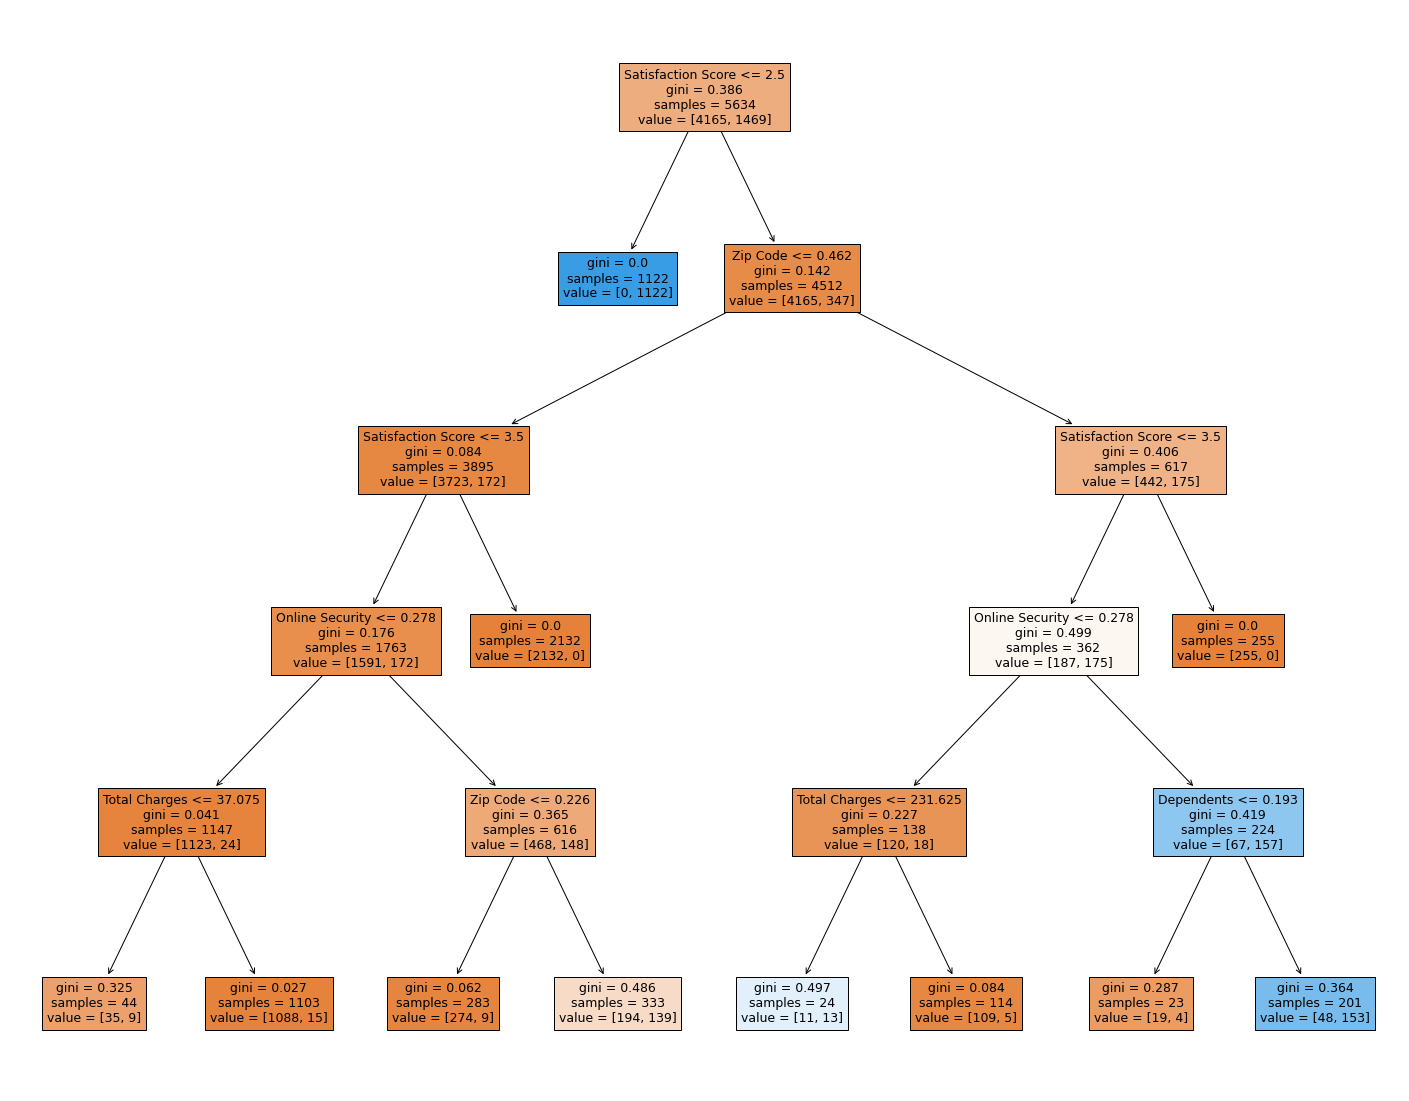

In [15]:
# 應該要刪掉變數讓解釋性提升
X_train_target_encoded = TargetEncoder().fit_transform(X=X_train,y=y_train)
decision_tree_for_plot = DecisionTreeClassifier(random_state=42,max_depth = 5)
decision_tree_for_plot.fit(X_train_target_encoded, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_for_plot, feature_names=X_train_target_encoded.columns, filled=True)

### Random forest

In [261]:
#-------------- Logistic regression Pipeline-------------
random_forest_clf_pipeline = Pipeline(steps=[
                 ('preprocessor', preprocessor), 
                 ('classifier', RandomForestClassifier(random_state=42,max_depth = 10))
                 ]
         )

# ---------------Modeling ----------------
random_forest_clf_pipeline.fit(X_train, y_train)


# ------------ ------ metrices--------------
# train metrices
train_y_pred = random_forest_clf_pipeline.predict(X_train)
train_y_pred_prob = random_forest_clf_pipeline.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, train_y_pred_prob)
train_f1 = f1_score(y_train, train_y_pred, average='macro')

# test metrices
y_pred = random_forest_clf_pipeline.predict(X_test)
y_pred_prob = random_forest_clf_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_prob)
test_f1 = f1_score(y_test, y_pred, average='macro')

print('Train AUC:',train_auc,'; ','Test AUC:',test_auc,'\n')
print('Train F1:',train_f1,';','Test F1',test_f1)

Train AUC: 0.8792030903579948 ;  Test AUC: 0.8442467789890981 

Train F1: 0.6007286010152402 ; Test F1 0.5823583346079826


### Xgboost

In [14]:
#-------------- Logistic regression Pipeline-------------
xgb_clf_pipeline = Pipeline(steps=[
                 ('preprocessor', preprocessor), 
                 ('classifier', XGBClassifier(scale_pos_weight = 2,  max_depth = 4, gamma = 0.2, min_child_weight = 3 ,random_state = 42)) # random state = 42的model 很不錯
                 ]
         )

# ---------------Modeling ----------------
xgb_clf_pipeline.fit(X_train, y_train)


# ------------ ------ metrices--------------
# train metrices
train_y_pred = xgb_clf_pipeline.predict(X_train)
train_y_pred_prob = xgb_clf_pipeline.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, train_y_pred_prob)
train_f1 = f1_score(y_train, train_y_pred, average='macro')

# test metrices
y_pred = xgb_clf_pipeline.predict(X_test)
y_pred_prob = xgb_clf_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_prob)
test_f1 = f1_score(y_test, y_pred, average='macro')

print('confusion_matrix:','\n',confusion_matrix(y_test, y_pred),'\n')

print('Train AUC:',train_auc,'; ','Test AUC:',test_auc,'\n')
print('Train F1:',train_f1,';','Test F1',test_f1)

confusion_matrix: 
 [[827 182]
 [109 291]] 

Train AUC: 0.9359465774056389 ;  Test AUC: 0.858831764122894 

Train F1: 0.8293207168282216 ; Test F1 0.7585261353898886


In [300]:
#X_test.assign(PRED_PROBA = y_pred_prob).assign(PRED = y_pred).assign(CHURN_VALUE = y_test).to_excel(r'C:\Users\byron_hsing\Documents\ML_side_project\telecom_customer_churn\predict_result.xlsx')

### plot cross validation accuracy

In [15]:
class get_accuracy: # input whole X and split to train and test, and get accuracy of different model 
    
    def __init__(self, X_train_local, y_train_local, fold_local, model_local, encoding_method_local):
        #-------- Encoding Pipeline-------------------
        if encoding_method_local == 'one_hot':
            preprocessor_local = ColumnTransformer(
               transformers=[
                   ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_feature)
            ], remainder='passthrough')
            
        elif encoding_method_local == 'target':
            preprocessor_local = ColumnTransformer(
               transformers=[
                   ('categorical', TargetEncoder(), categorical_feature)
            ], remainder='passthrough')

        #--------  Modeling Pipeline-------------------
        if model_local == 'logistic_regression':
            clf_pipeline = Pipeline(steps=[
                             ('preprocessor', preprocessor_local), 
                             ('classifier', LogisticRegression(random_state=42,max_iter = 1000))
                             ]
                     )

        elif model_local == 'decision_tree':
            clf_pipeline = Pipeline(steps=[
                     ('preprocessor', preprocessor_local), 
                     ('classifier', DecisionTreeClassifier(max_depth = 4,random_state=42))
                     ]
             )

        elif model_local == 'random_forest':
            clf_pipeline = Pipeline(steps=[
                     ('preprocessor', preprocessor_local), 
                     ('classifier', RandomForestClassifier(max_depth = 10,random_state=42))
                     ]
             )


        elif model_local == 'xgboost':
            clf_pipeline = Pipeline(steps=[
                     ('preprocessor', preprocessor_local), 
                     ('classifier', XGBClassifier(scale_pos_weight = 2,  max_depth = 4, gamma = 0.2, min_child_weight = 3 ,random_state=42))
                     ]
             )


        # ---------------Modeling - Cross Validation----------------
        # determine CV
        cv = ShuffleSplit(n_splits=fold_local, random_state=42)
        #cv = StratifiedKFold(n_splits=fold_local, random_state=42)
        
        cv_score_f1 = cross_val_score(estimator=clf_pipeline,
                     X=X_train_local,
                     y=y_train_local,
                     cv=cv,
                     scoring='f1')

        cv_score_auc = cross_val_score(estimator=clf_pipeline,
                     X=X_train_local,
                     y=y_train_local,
                     cv=cv,
                     scoring='roc_auc')


        # ------------ ------ metrices--------------
        self.test_auc = cv_score_auc
        self.test_f1 = cv_score_f1

In [16]:
#----------------- Target --------------
# AUC
logistic_auc_te = get_accuracy(X_train, y_train, 5, 'logistic_regression', 'target').test_auc
decision_tree_auc_te = get_accuracy(X_train, y_train, 5, 'decision_tree', 'target').test_auc
random_forest_auc_te =get_accuracy(X_train, y_train, 5, 'random_forest', 'target').test_auc
xgboost_auc_te = get_accuracy(X_train, y_train, 5, 'xgboost', 'target').test_auc

# F1
logistic_f1_te = get_accuracy(X_train, y_train, 5, 'logistic_regression', 'target').test_f1
decision_tree_f1_te = get_accuracy(X_train, y_train, 5, 'decision_tree', 'target').test_f1
random_forest_f1_te =get_accuracy(X_train, y_train, 5, 'random_forest', 'target').test_f1
xgboost_f1_te = get_accuracy(X_train, y_train, 5, 'xgboost', 'target').test_f1

#----------------- One hot  --------------
# AUC
logistic_auc_hot = get_accuracy(X_train, y_train, 5, 'logistic_regression', 'one_hot').test_auc
decision_tree_auc_hot = get_accuracy(X_train, y_train, 5, 'decision_tree', 'one_hot').test_auc
random_forest_auc_hot =get_accuracy(X_train, y_train, 5, 'random_forest', 'one_hot').test_auc
xgboost_auc_hot = get_accuracy(X_train, y_train, 5, 'xgboost', 'one_hot').test_auc

# F1
logistic_f1_hot = get_accuracy(X_train, y_train, 5, 'logistic_regression', 'one_hot').test_f1
decision_tree_f1_hot = get_accuracy(X_train, y_train, 5, 'decision_tree', 'one_hot').test_f1
random_forest_f1_hot =get_accuracy(X_train, y_train, 5, 'random_forest', 'one_hot').test_f1
xgboost_f1_hot = get_accuracy(X_train, y_train, 5, 'xgboost', 'one_hot').test_f1

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.co

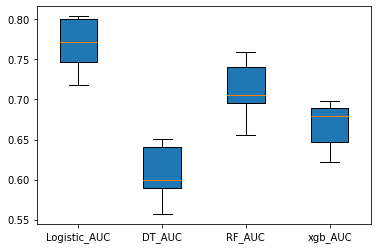

In [289]:
# AUC - Target Encoding
plt.boxplot([logistic_auc_te,decision_tree_auc_te,random_forest_auc_te,xgboost_auc_te],
            patch_artist=True,
            labels=['Logistic_AUC','DT_AUC','RF_AUC','xgb_AUC'])
plt.show()

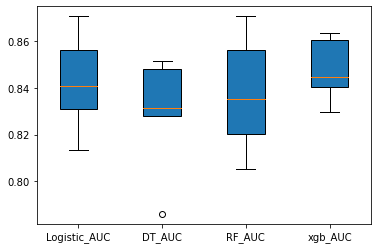

In [293]:
# AUC -One Hot
plt.boxplot([logistic_auc_hot,decision_tree_auc_hot,random_forest_auc_hot,xgboost_auc_hot],
            patch_artist=True,
            labels=['Logistic_AUC','DT_AUC','RF_AUC','xgb_AUC'])
plt.show()

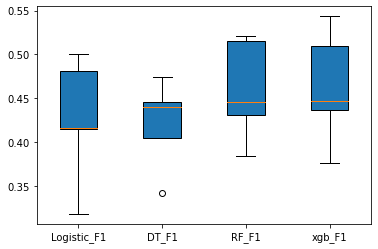

In [291]:
# F1 - Target Encoding
plt.boxplot([logistic_f1_te,decision_tree_f1_te,random_forest_f1_te,xgboost_f1_te],
            patch_artist=True,
            labels=['Logistic_F1','DT_F1','RF_F1','xgb_F1'])
plt.show()

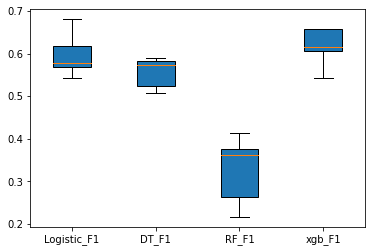

In [292]:
# F1 - One Hot
plt.boxplot([logistic_f1_hot,decision_tree_f1_hot,random_forest_f1_hot,xgboost_f1_hot],
            patch_artist=True,
            labels=['Logistic_F1','DT_F1','RF_F1','xgb_F1'])
plt.show()

# 模型解釋

### Permutation importance - use simpel model with one hot encoding

In [17]:
# ---------------Train test split-------------- 
simple_model_feature_keep = ['City','Senior Citizen','Partner','Dependents','Contract','Tenure Months','Tech Support','Payment Method','Churn Value']
simple_data = all_data_drop[simple_model_feature_keep]

simple_X = simple_data.drop(['Churn Value'],axis = 1)
simple_y = simple_data['Churn Value']
simple_X_train, simple_X_test, simple_y_train, simple_y_test = train_test_split(simple_X, simple_y, test_size=0.2 ,random_state = 42)

# -------------- setting feature type-------------- 
simple_numeric_feature = simple_X.select_dtypes(exclude=['O']).columns.to_list()
simple_categorical_feature = simple_X.select_dtypes(include=['O']).columns.to_list()

#-------------- Encoding Pipeline-------------


simple_preprocessor = ColumnTransformer(
   transformers=[
       ('categorical', OneHotEncoder(handle_unknown='ignore'), simple_categorical_feature)
], remainder='passthrough')



#-------------- XGB Pipeline-------------
simple_xgb_clf_pipeline = Pipeline(steps=[
                 ('preprocessor', simple_preprocessor), 
                 ('classifier', XGBClassifier(scale_pos_weight = 2,  max_depth = 4, gamma = 0.2, min_child_weight = 3 ,random_state = 42))
                 ]
         )

# ---------------Modeling ----------------
simple_xgb_clf_pipeline.fit(simple_X_train, simple_y_train)


# ------------ ------ metrices--------------
# train metrices
simple_train_y_pred = simple_xgb_clf_pipeline.predict(simple_X_train)
simple_train_y_pred_prob = simple_xgb_clf_pipeline.predict_proba(simple_X_train)[:, 1]
simple_train_auc = roc_auc_score(simple_y_train, simple_train_y_pred_prob)
simple_train_f1 = f1_score(simple_y_train, simple_train_y_pred, average='macro')

# test metrices
simple_y_pred = simple_xgb_clf_pipeline.predict(simple_X_test)
simple_y_pred_prob = simple_xgb_clf_pipeline.predict_proba(simple_X_test)[:, 1]
simple_test_auc = roc_auc_score(simple_y_test, simple_y_pred_prob)
simple_test_f1 = f1_score(simple_y_test, simple_y_pred, average='macro')

print('Train AUC:',simple_train_auc,'; ','Test AUC:',simple_test_auc,'\n')
print('Train F1:',simple_train_f1,';','Test F1',simple_test_f1,'\n')

print('Fearure importance:','\n',simple_xgb_clf_pipeline['classifier'].feature_importances_)

Train AUC: 0.8785614994806636 ;  Test AUC: 0.83896432111001 

Train F1: 0.7588975145934886 ; Test F1 0.7273583189170925 

Fearure importance: 
 [0.         0.         0.         ... 0.03564093 0.01587228 0.01602404]


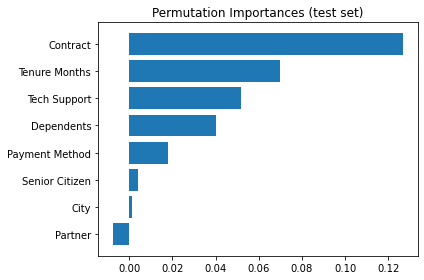

4    0.126848
5    0.069959
6    0.051966
3    0.040294
7    0.018152
1    0.004064
0    0.001333
2   -0.007629
dtype: float64


In [20]:
# ------------------------------ Permutation Importance ------------------------------
importance = permutation_importance(simple_xgb_clf_pipeline, simple_X_test, simple_y_test,n_repeats=30, random_state=42,scoring = 'f1')

sorted_idx = importance.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(simple_X_test.columns[sorted_idx], importance.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

print(pd.Series(importance.importances_mean).sort_values(ascending=False))

### SHAP - use simpel model with target encoding

In [23]:
# ---------------Train test split-------------- 
simple_model_feature_keep = ['City','Senior Citizen','Partner','Dependents','Contract','Tenure Months','Tech Support','Payment Method','Churn Value']
simple_data = all_data_drop[simple_model_feature_keep]

simple_X = simple_data.drop(['Churn Value'],axis = 1)
simple_y = simple_data['Churn Value']
simple_X_train, simple_X_test, simple_y_train, simple_y_test = train_test_split(simple_X, simple_y, test_size=0.2 ,random_state = 42)

# -------------- setting feature type-------------- 
simple_numeric_feature = simple_X.select_dtypes(exclude=['O']).columns.to_list()
simple_categorical_feature = simple_X.select_dtypes(include=['O']).columns.to_list()

#-------------- Encoding Pipeline-------------


simple_preprocessor = ColumnTransformer(
   transformers=[
   ('categorical', TargetEncoder(cols=simple_categorical_feature), simple_categorical_feature)
], remainder='passthrough'
)


#-------------- XGB  Pipeline-------------
simple_xgb_clf_pipeline = Pipeline(steps=[
                 ('preprocessor', simple_preprocessor), 
                 ('classifier', XGBClassifier(scale_pos_weight = 2,  max_depth = 4, gamma = 0.2, min_child_weight = 3 ,random_state = 42))
                 ]
         )

# ---------------Modeling ----------------
simple_xgb_clf_pipeline.fit(simple_X_train, simple_y_train)


# ------------ ------ metrices--------------
# train metrices
simple_train_y_pred = simple_xgb_clf_pipeline.predict(simple_X_train)
simple_train_y_pred_prob = simple_xgb_clf_pipeline.predict_proba(simple_X_train)[:, 1]
simple_train_auc = roc_auc_score(simple_y_train, simple_train_y_pred_prob)
simple_train_f1 = f1_score(simple_y_train, simple_train_y_pred, average='macro')

# test metrices
simple_y_pred = simple_xgb_clf_pipeline.predict(simple_X_test)
simple_y_pred_prob = simple_xgb_clf_pipeline.predict_proba(simple_X_test)[:, 1]
simple_test_auc = roc_auc_score(simple_y_test, simple_y_pred_prob)
simple_test_f1 = f1_score(simple_y_test, simple_y_pred, average='macro')

print('Train AUC:',simple_train_auc,'; ','Test AUC:',simple_test_auc,'\n')
print('Train F1:',simple_train_f1,';','Test F1',simple_test_f1,'\n')

print('Fearure importance:','\n',simple_xgb_clf_pipeline['classifier'].feature_importances_)

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Train AUC: 0.9493680113297872 ;  Test AUC: 0.7249108027750247 

Train F1: 0.842583750802344 ; Test F1 0.6743608262314025 

Fearure importance: 
 [0.10339086 0.02680181 0.02987308 0.16976823 0.49609384 0.10366892
 0.04001254 0.03039075]


In [24]:
# ------------------------------ SHAP ------------------------------
shap.initjs()
encoded_simple_X_test = simple_preprocessor.transform(simple_X_test)
encoded_simple_X_test = pd.DataFrame(encoded_simple_X_test)
explainer =shap.TreeExplainer(simple_xgb_clf_pipeline['classifier'],encoded_simple_X_test)
encoded_simple_X_test.columns = simple_X_test.columns
shap_values = explainer(encoded_simple_X_test)

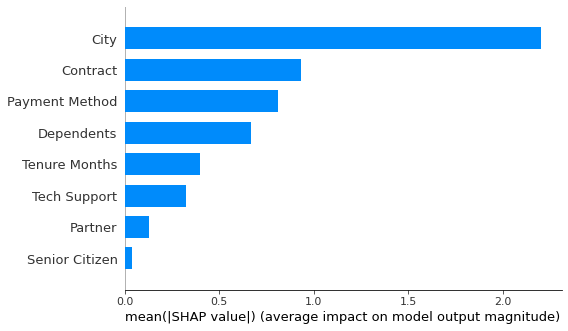

In [25]:
shap.summary_plot(shap_values, encoded_simple_X_test, plot_type="bar")

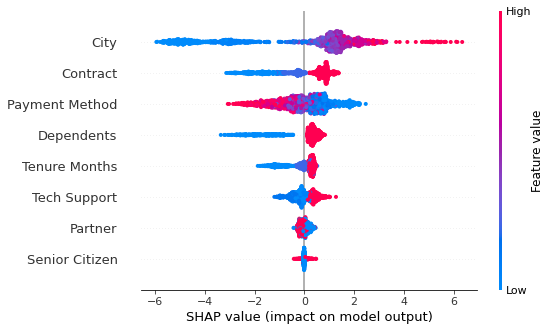

In [44]:
shap.summary_plot(shap_values, encoded_simple_X_test)

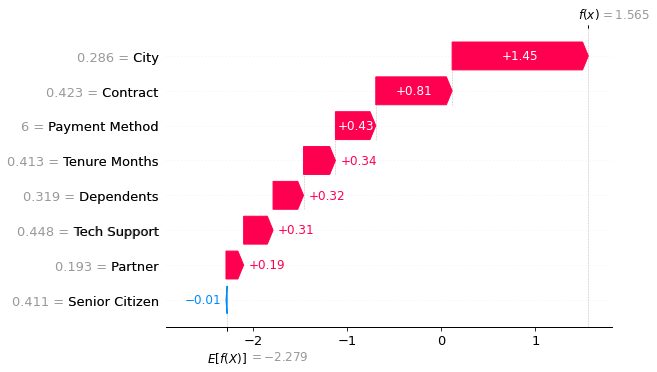

In [23]:
shap.plots.waterfall(shap_values[3])

In [22]:
simple_X_test.reset_index(drop=True).iloc[3,:]

City                  Sherman Oaks
Senior Citizen                 Yes
Partner                        Yes
Dependents                      No
Contract            Month-to-month
Tenure Months                    6
Tech Support                    No
Payment Method    Electronic check
Name: 3, dtype: object